# Gaussian Mixture Models

This notebook fits a gaussian mixture model to univariate data using a hand-coded expectation maximization algorithm. It proceeds as follows:
1. Read in the dataset.
2. Select an appropriate variable to fit the model to.
3. Define the number of components to be fit.
4. Implement EM to fit the components.
5. Display the resulting distribution, overlaid on the training data.
6. Review and discussion of existing Python tools to simplify the procedure.

We're going to be using data from the World Happiness Report (https://www.kaggle.com/unsdsn/world-happiness). 155 countries, 12 features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

happiness_data = pd.read_csv('.\\data\\world-happiness-report\\2017.csv')
happiness_data.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


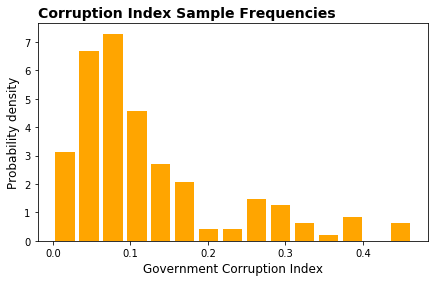

In [2]:
plt.figure(figsize = (7, 4))
plt.hist(happiness_data['Trust..Government.Corruption.'], 
         bins = 15, normed = True, histtype = 'bar', rwidth = 0.8, color = 'orange');
plt.xlabel('Government Corruption Index', fontsize = 12); plt.ylabel('Probability density', fontsize = 12);
plt.title('Corruption Index Sample Frequencies', loc = 'left', fontweight = 'bold', fontsize = 14);

In [3]:
# Extract the column of corruption measurements
x = happiness_data['Trust..Government.Corruption.'].as_matrix()

# Define the number of gaussians to fit
n_components = 2

# Create parameter vectors for these gaussians
    # Means of each component
mu         = np.array([np.random.uniform(0, 1) for j in range(n_components)])
    # Component weights (Must sum to 1)
split_locs = sorted([np.random.uniform(0, 1) for j in range(n_components - 1)])
lam        = np.array([split_locs[0]] + 
                      [(split_locs[j+1] - split_locs[j]) for j in range(0, n_components - 2)] + 
                      [1 - split_locs[-1]])
    # Variances
var        = np.array([np.random.uniform(1e-5, 0.1) for j in range(n_components)])

In [4]:
# Define a normal density function
def dnorm(x, mu, var):
    return np.exp(-(x - mu)**2 / (2*var)) / np.sqrt(2*np.pi*var)

In [5]:
def dMoG(x, mu, var, lam):
    # Returns a probability density of x for given mixture of gaussians
    # x is a scalar; {mu, var, lam} are vectors describing each univariate gaussian (lam are their weights)
    x_pd = 0
    for k in range(len(mu)):
        x_pd = x_pd + dnorm(x, mu[k], var[k])*lam[k]
    return x_pd

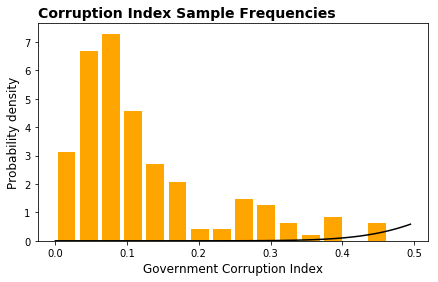

In [6]:
# Plot the initialization state of the distributions
plt.figure(figsize = (7, 4))
plt.hist(happiness_data['Trust..Government.Corruption.'], 
         bins = 15, normed = True, histtype = 'bar', rwidth = 0.8, color = 'orange');
plt.xlabel('Government Corruption Index', fontsize = 12); plt.ylabel('Probability density', fontsize = 12);
plt.title('Corruption Index Sample Frequencies', loc = 'left', fontweight = 'bold', fontsize = 14);
plt.plot(np.arange(0, .5, 0.005), dMoG(np.arange(0, .5, 0.005), mu, var, lam), color = 'black');
plt.savefig('Mog_unfit.pdf', dpi = 500)

We can see that the initialized mixture of gaussians is a poor representation of the true frequency distribution: the model's parameters need to be fit. To do this we'll use the expectation maximization algorithm. Here the hidden variable takes on integer values indexing the normal distributions. 
The algorithm proceeds as:
1. E-step: Raise the boundary w.r.t. the hidden variable's density function - update these functions according to the data and the parameters. This is posterior probability calculation:
$$
    q_i(h_i = k) = \text{Pr}(h_i = k \ | \ x_i, \theta^{[t]}) = \frac{\text{Norm}_{x_i}[\mu_k, \sigma^2_k] \cdot \lambda_k}{\sum_{j = 1}^{K}\text{Norm}_{x_i}[\mu_j, \sigma^2_j] \cdot \lambda_j} = r_{ik}\\[1.5em]
$$
Where $\theta$ denotes the set of parameters $\{\mu, \sigma^2, \lambda\}$. Evaluating this density function for a datapoint $x_i$ and a chosen distribution $k$ returns the probability that that distribution is responsible for the input datapoint.

2. M-step: Maximize the boundary's value w.r.t. the model parameters $\{\mu, \sigma^2, \lambda\}$. This can be done analytically for a mixture of gaussians according to the update rules:
$$
    \lambda_k^{[t+1]} = \frac{\sum_{i=1}^{I}r_{ik}}{\sum_{j=1}^{K}\sum_{i = 1}^{I}r_{ij}} \\[1.5em]
    \mu_{k}^{[t+1]} = \frac{\sum_{i = 1}^{I}r_{ik}x_{i}}{\sum_{i=1}^{I}r_{ik}} \\[1.5em]
    {\sigma^2}_{k}^{[t+1]} = \frac{\sum_{i=1}^{I}r_{ik}(x_i - \mu_k^{[t+1]})^2}{\sum_{i=1}^{I}r_{ik}}
$$

Where $I$ is the number of training examples, $K$ the number of gaussians being fit, $t$ the update iteration, and $r_{ik}$ is the posterior probability distribution of the hidden variable found during the preceding E-step.


In [7]:
def E_step(x, mu, var, lam):
    # Returns an I x K matrix of responsibility values
    # x is a length-I vector of observations; mu, var, lam are length-K vectors of parameters
    # Iterate over observations
    r = np.zeros([len(x), len(mu)])
    for i in range(len(x)):
        xi_unnorm_posterior = np.array([lam[k]*dnorm(x[i], mu[k], var[k]) for k in range(len(mu))])
        xi_evidence = np.sum(xi_unnorm_posterior) # Length-k row vector
        r[i, :] = xi_unnorm_posterior/xi_evidence
    return r

In [8]:
def M_step(x, r, mu):
    # Updates the parameters to maximize the boundary's value
    lam = np.sum(r, axis = 0)/np.sum(r)
    mu  = (np.matmul(x, r)).T/np.sum(r, axis = 0)
    var = np.sum(r*np.array([(mu - x_i)**2 for x_i in x]), axis = 0)/np.sum(r, axis = 0)
    return [mu, var, lam]

In [9]:
def compute_boundary(x, r, mu, var, lam):
    bound = 0
    for i in range(len(x)):
        for k in range(len(lam)):
            bound = bound + r[i,k]*np.log(lam[k]*dnorm(x[i], mu[k], var[k])/r[i, k])
    return bound

In [10]:
# EM algorithm:
# - Accepts a vector of observations and the initial mu, lambda, sigma^2 values for each gaussian
# - Returns mu, lamda, sigma^2 values at convergence
def fit_MoG(x, mu, var, lam):
    bound = 1; upd_bound = 0;
    while abs(bound - upd_bound) > 1e-5:
        bound = upd_bound
        r              = E_step(x, mu, var, lam)
        [mu, var, lam] = M_step(x, r, mu)        # Returns parameters that maximize boundary value
        upd_bound      = compute_boundary(x, r, mu, var, lam) # Returns value of boundary for given parameters
    return [mu, var, lam]

In [11]:
[mu, var, lam] = fit_MoG(x, mu, var, lam)

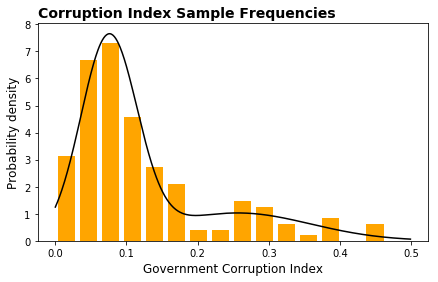

In [12]:
plt.figure(figsize = (7, 4))
plt.hist(happiness_data['Trust..Government.Corruption.'], 
         bins = 15, normed = True, histtype = 'bar', rwidth = 0.8, color = 'orange');
plt.xlabel('Government Corruption Index', fontsize = 12); plt.ylabel('Probability density', fontsize = 12);
plt.title('Corruption Index Sample Frequencies', loc = 'left', fontweight = 'bold', fontsize = 14);
plt.plot(np.arange(0, .5, 0.001), dMoG(np.arange(0, .5, 0.001), mu, var, lam), color = 'black');
plt.savefig('Mog_fit.pdf', dpi = 500)